**NAME** - Aritra Sarkar

**ROLL NO** - 20QM30001

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms


Downloading the MNIST dataset

In [ ]:
transform = transforms.ToTensor()

#Loading the training set
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

#Loading the test set
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)



Combining the training and testing sets together to calculate the grand mean and standard deviation

In [ ]:
#I have combined the train and test data together to calculate the mean and standard deviation
combined_data = torch.cat([next(iter(trainloader))[0], next(iter(testloader))[0]], dim=0)

mean=combined_data.mean()
std_dev=combined_data.std()



In [ ]:
print(mean.item()," ",std_dev.item())

0.13092534244060516   0.30844852328300476


Normalizing the dataset using the mean and standard deviation

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean,), (std_dev,))])

#Next, I have used the mean and standard deviation to Normalize the
normalized_training_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
normalized_test_set = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

Using a batch size=300 to get training and testing mini-batches

In [ ]:
batch_size = 300 #As instructed in the question, the batch_size should be greater than 256 for both training and test sets
trainloader = torch.utils.data.DataLoader(normalized_training_set, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(normalized_test_set, batch_size=batch_size, shuffle=False)


Next, I have created the **ResNet** architecture by building it from scratch. As mentioned in the question, I have used 2 level Resnet block, used 2 Convolution layers(along with **MaxPooling** and **ReLU** activations) and residual connections. At the end, I have added 2 fully-connected layers and finally the output layer having 10 output Neurons.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define a convolutional layer with 3x3 kernel
def convo(input_channels, output_channels, stride=1):
    return nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=True)

# Defining a basic residual block with skip connection
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = convo(input_channels, output_channels, stride)
        self.conv2 = convo(output_channels, output_channels)
        self.shortcut = nn.Sequential()
        if(stride != 1 or input_channels != output_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        output = nn.ReLU()(self.conv1(x))
        output = (self.conv2(output))
        output = output + self.shortcut(x)  # Adding the shortcut(or residual) connection
        output = nn.ReLU()(output)
        return output

# Defining a single ResNet layer
def ResNet_Layer(block, input_channels, output_channels,stride):

    layers_list=[]
    layers_list.append(block(input_channels, output_channels, stride))
    input_channels = output_channels  # Update input channels for next block in the layer
    return nn.Sequential(*layers_list)

# Define the ResNet architecture
def ResNet(num_classes=10):
    # Start with a 3x3 convolutional layer, followed by batch normalization and ReLU
    layers_list = [
        convo(1, 16),        # Input channels: 1 (grayscale image), Output channels: 16
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer(as demonstrated in class)
        ]
    # Add the ResNet layers
    layers_list.append(ResNet_Layer(Block, 16, 16, 1))  # First ResNet level
    layers_list.append(ResNet_Layer(Block, 16, 32, 2))  # Second ResNet level
    # Average pooling
    layers_list.append(nn.AdaptiveAvgPool2d((1, 1))) #Average Pooling layer before Flatten(as demonstrated in class)
    layers_list.append(nn.Flatten())
    # Fully connected layers
    layers_list.append(nn.Linear(32, 64))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Linear(64, num_classes))  # Output layer with num_classes neurons
    layers_list.append(nn.Sigmoid())
    return nn.Sequential(*layers_list)

# Testing the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model=ResNet().to(device)
print(my_model)
summary(my_model, input_size=(1, 28, 28)) # As input size of each image in MNIST is (1 x 28 x 28)



Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
    )
  )
  (4): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      )
    )
  )
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32, out_features=64, bias=True)
  (8): ReLU(inplace=True)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): Sigmoid()
)
---------------

Hence, there are a total of 21,994 trainable parameters in the above model

Next, I have removed the skip or residual connection from the ResNet block to create CNN-Vanilla. The rest all architecture remains the same.  

In [ ]:
# Define a convolutional layer with 3x3 kernel
def convo(input_channels, output_channels, stride=1):
    return nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=True)

# Defining a basic residual block without any skip connection
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = convo(input_channels, output_channels, stride)
        self.conv2 = convo(output_channels, output_channels)



    def forward(self, x):
        output = nn.ReLU()(self.conv1(x))
        output = (self.conv2(output))
        output = nn.ReLU()(output)
        return output

# Defining a CNN-Vanilla level(same basic structure as that of CNN-ResNet)
def Vanilla_Layer(block, input_channels, output_channels,stride):

    layers_list = []

    layers_list.append(block(input_channels, output_channels, stride))
    in_channels = output_channels  # Update input channels for next block in the layer
    return nn.Sequential(*layers_list)

# Define the ResNet architecture
def Vanilla(num_classes=10):
    # Start with a 3x3 convolutional layer, followed by batch normalization and ReLU
    layers_list = [
        convo(1, 16),        # Input channels: 1 (grayscale image), Output channels: 16
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer(as demonstrated in class)
    ]
    # Add the ResNet layers
    layers_list.append(Vanilla_Layer(Block, 16, 16, 1))  # First Vanilla level
    layers_list.append(Vanilla_Layer(Block, 16, 32, 2))  # Second Vanilla level
    # Average pooling
    layers_list.append(nn.AdaptiveAvgPool2d((1, 1)))
    layers_list.append(nn.Flatten())
    # Fully connected layers
    layers_list.append(nn.Linear(32, 64))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Linear(64, num_classes))  # Output layer with num_classes neurons
    layers_list.append(nn.Sigmoid())
    return nn.Sequential(*layers_list)

# Testing the network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model_2=Vanilla().to(device)
print(my_model_2)
summary(my_model_2, input_size=(1, 28, 28)) # As input size of each image in MNIST is (1 x 28 x 28)



Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (4): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32, out_features=64, bias=True)
  (8): ReLU(inplace=True)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d

There are a total of 21,450 trainable parameters in the CNN-Vanilla network.(above) Hence, the no. of parameters decrease as compared to CNN-ResNet

I have used my CNN-ResNet model(my_model) for training using the normalized dataset

Epoch 1/30: Training loss = 2.061361753940582
Epoch 2/30: Training loss = 1.7736898267269134
Epoch 3/30: Training loss = 1.6481583297252655
Epoch 4/30: Training loss = 1.6142249065637588
Epoch 5/30: Training loss = 1.5909749174118042
Epoch 6/30: Training loss = 1.5526673322916031
Epoch 7/30: Training loss = 1.5321544700860976
Epoch 8/30: Training loss = 1.5224400836229324
Epoch 9/30: Training loss = 1.5171410125494003
Epoch 10/30: Training loss = 1.5122455382347106
Epoch 11/30: Training loss = 1.509059534072876
Epoch 12/30: Training loss = 1.507209061384201
Epoch 13/30: Training loss = 1.5049012130498887
Epoch 14/30: Training loss = 1.504767890572548
Epoch 15/30: Training loss = 1.5023568910360336
Epoch 16/30: Training loss = 1.499708158969879
Epoch 17/30: Training loss = 1.4976573008298875
Epoch 18/30: Training loss = 1.4963599240779877
Epoch 19/30: Training loss = 1.4952141332626343
Epoch 20/30: Training loss = 1.4940448027849198
Epoch 21/30: Training loss = 1.4949631100893022
Epoch 

Text(0, 0.5, 'Training loss')

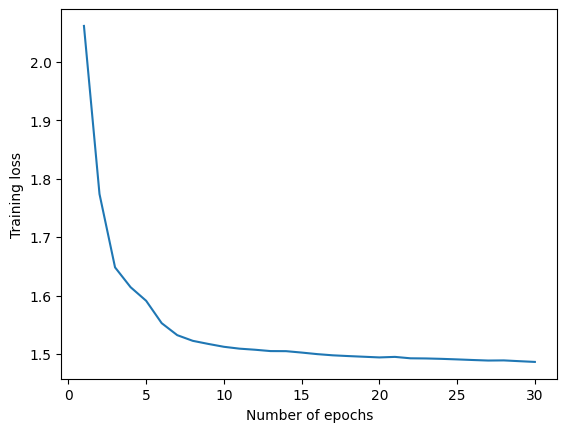

In [ ]:
#Defining the model hyper parameters
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_ResNet = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_ResNet.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list_ResNet[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_ResNet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")


Accuracy on the test set: 97.3500%


Hence, I got an accuracy of 97.35% on the test set using my_model(above)

Next, I have used my CNN-Vanilla model(my_model_2) for training using the normalized dataset.

Epoch 1/30: Training loss = 2.0790654891729354
Epoch 2/30: Training loss = 1.816932837367058
Epoch 3/30: Training loss = 1.6505686581134795
Epoch 4/30: Training loss = 1.59936704993248
Epoch 5/30: Training loss = 1.5723541700839996
Epoch 6/30: Training loss = 1.5497856384515762
Epoch 7/30: Training loss = 1.5391965478658676
Epoch 8/30: Training loss = 1.527297813296318
Epoch 9/30: Training loss = 1.5227702981233597
Epoch 10/30: Training loss = 1.5162915122509002
Epoch 11/30: Training loss = 1.5113046884536743
Epoch 12/30: Training loss = 1.5092804324626923
Epoch 13/30: Training loss = 1.5045385426282882
Epoch 14/30: Training loss = 1.5030351316928863
Epoch 15/30: Training loss = 1.5005958539247513
Epoch 16/30: Training loss = 1.4978062385320663
Epoch 17/30: Training loss = 1.49733349442482
Epoch 18/30: Training loss = 1.4948333632946014
Epoch 19/30: Training loss = 1.494069921374321
Epoch 20/30: Training loss = 1.4928750932216643
Epoch 21/30: Training loss = 1.4909059816598893
Epoch 22

Text(0, 0.5, 'Training loss')

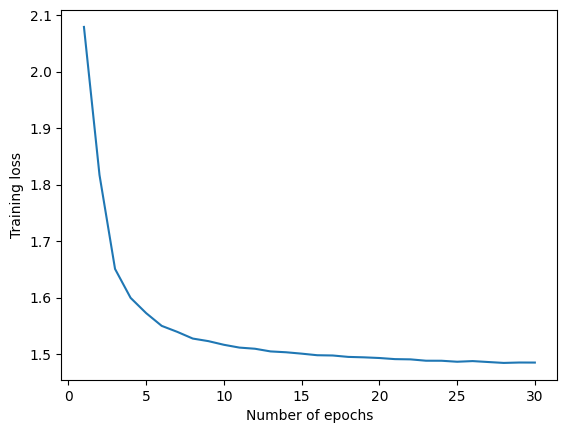

In [ ]:
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model_2.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_Vanilla = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model_2.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model_2(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_Vanilla.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list_Vanilla[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_Vanilla)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model_2.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model_2(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")


Accuracy on the test set: 97.0600%


Hence, my 1st model(that is ResNet - my_model) provides better accuracy(97.65%) as compared to my 2nd model(that is Vanilla - my_model_2) with accuracy 97.06%. Also if we look at the number of Trainable parameters, it is 21,994 for my_model and 21,450 for my_model_2. Hence, there is not much difference. Therefore, I will prefer to use my_model(ResNet) for my next Experiment.

**EXPERIMENT NO(2)**

As suggested in Experiment-2, I will use the un-normalized dataset for training and use my_model. Hence, I have extracted the un-normalized dataset again in the next cell. I have already done the same experiment using the normalized dataset and my_model. So, I am not repeating the same training procedure again

In [ ]:
transform = transforms.ToTensor()
BATCH_SIZE=300
#Loading the training set
trainset_1 = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader_1 = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

#Loading the test set
testset_1 = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader_1 = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

I will perform training using my_model

Epoch 1/30: Training loss = 2.13126833319664
Epoch 2/30: Training loss = 1.9199498999118805
Epoch 3/30: Training loss = 1.8131529706716538
Epoch 4/30: Training loss = 1.725165866613388
Epoch 5/30: Training loss = 1.674343558549881
Epoch 6/30: Training loss = 1.6396436750888825
Epoch 7/30: Training loss = 1.607701562643051
Epoch 8/30: Training loss = 1.584204815030098
Epoch 9/30: Training loss = 1.5701019102334977
Epoch 10/30: Training loss = 1.5553354108333588
Epoch 11/30: Training loss = 1.540323566198349
Epoch 12/30: Training loss = 1.5297032636404038
Epoch 13/30: Training loss = 1.5234087938070298
Epoch 14/30: Training loss = 1.5180015671253204
Epoch 15/30: Training loss = 1.5139425855875015
Epoch 16/30: Training loss = 1.5105297166109084
Epoch 17/30: Training loss = 1.5077299642562867
Epoch 18/30: Training loss = 1.504911561012268
Epoch 19/30: Training loss = 1.5040644842386246
Epoch 20/30: Training loss = 1.5011588805913925
Epoch 21/30: Training loss = 1.4994340133666992
Epoch 22/

Text(0, 0.5, 'Training loss')

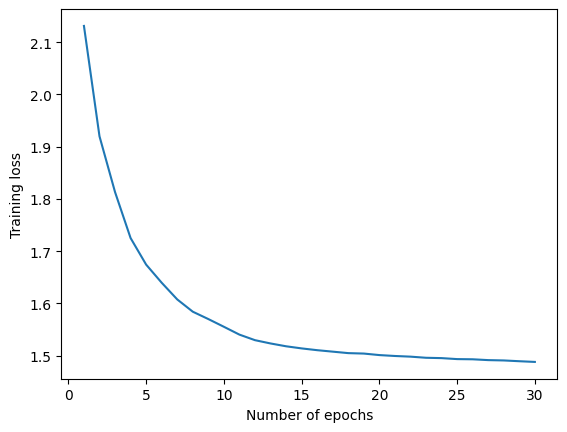

In [ ]:
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_ResNet = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model.train()
	for i, (images, labels) in enumerate(trainloader_1):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_ResNet.append(train_loss/len(trainloader_1))
	print(f"Training loss = {train_loss_list_ResNet[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_ResNet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
my_model.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader_1:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")


Accuracy on the test set: 97.1900%


So, The accuracy in the test set using the not normalized dataset is 97.19%. Therefore, it decreases a bit as compared to that of the normalized dataset(which was 97.65%). So, I will prefer to use Normalized dataset and my_model(ResNet model) for the next experiment.

**EXPERIMENT NO - (3)**

As suggested in **Experiment 3**, I have used different optimizers - mini-batch gradient descent, mini-batch gradient descent with momentum, and Adam Optimizer(which I am using by default) on top of my_model and used the normalized dataset. I have already used Adam Optimizer earlier(in my_model) with the normalized dataset. So, I am not repeating the same training procedure again

(1) Using Mini-batch without momentum

Epoch 1/30: Training loss = 2.3026526498794557
Epoch 2/30: Training loss = 2.302636765241623
Epoch 3/30: Training loss = 2.302621477842331
Epoch 4/30: Training loss = 2.3026065397262574
Epoch 5/30: Training loss = 2.302591856718063
Epoch 6/30: Training loss = 2.3025772976875305
Epoch 7/30: Training loss = 2.302562795877457
Epoch 8/30: Training loss = 2.3025483000278473
Epoch 9/30: Training loss = 2.3025337719917296
Epoch 10/30: Training loss = 2.3025191402435303
Epoch 11/30: Training loss = 2.302504462003708
Epoch 12/30: Training loss = 2.3024896597862243
Epoch 13/30: Training loss = 2.302474697828293
Epoch 14/30: Training loss = 2.3024596071243284
Epoch 15/30: Training loss = 2.302444236278534
Epoch 16/30: Training loss = 2.3024285888671874
Epoch 17/30: Training loss = 2.3024128139019013
Epoch 18/30: Training loss = 2.302396916151047
Epoch 19/30: Training loss = 2.3023809254169465
Epoch 20/30: Training loss = 2.3023648977279665
Epoch 21/30: Training loss = 2.3023489725589754
Epoch 22/

Text(0, 0.5, 'Training loss')

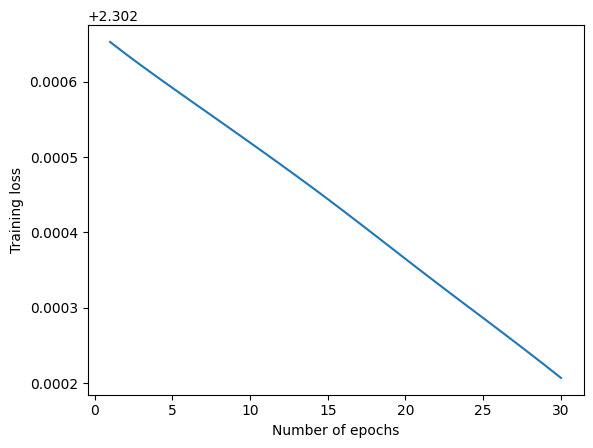

In [ ]:
#Defining the model hyper parameters
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate)

#Training process begins
train_loss_list= []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")


Accuracy on the test set: 9.8000%


We find that it provides very less accuracy with the test set and the training loss also does not decrease in an ideal manner.(above)

Next, I will be using mini-batch gradient descent with momentum=0.9

Epoch 1/30: Training loss = 2.3027929508686067
Epoch 2/30: Training loss = 2.302589987516403
Epoch 3/30: Training loss = 2.302409255504608
Epoch 4/30: Training loss = 2.302239146232605
Epoch 5/30: Training loss = 2.3020716953277587
Epoch 6/30: Training loss = 2.3018926763534546
Epoch 7/30: Training loss = 2.3017105317115782
Epoch 8/30: Training loss = 2.301545535326004
Epoch 9/30: Training loss = 2.3013779091835023
Epoch 10/30: Training loss = 2.301198137998581
Epoch 11/30: Training loss = 2.300992990732193
Epoch 12/30: Training loss = 2.300789396762848
Epoch 13/30: Training loss = 2.300575933456421
Epoch 14/30: Training loss = 2.300355257987976
Epoch 15/30: Training loss = 2.3001246666908264
Epoch 16/30: Training loss = 2.299882208108902
Epoch 17/30: Training loss = 2.2996193063259125
Epoch 18/30: Training loss = 2.2993304681777955
Epoch 19/30: Training loss = 2.2990086925029756
Epoch 20/30: Training loss = 2.2986459410190583
Epoch 21/30: Training loss = 2.2982312834262846
Epoch 22/30

Text(0, 0.5, 'Training loss')

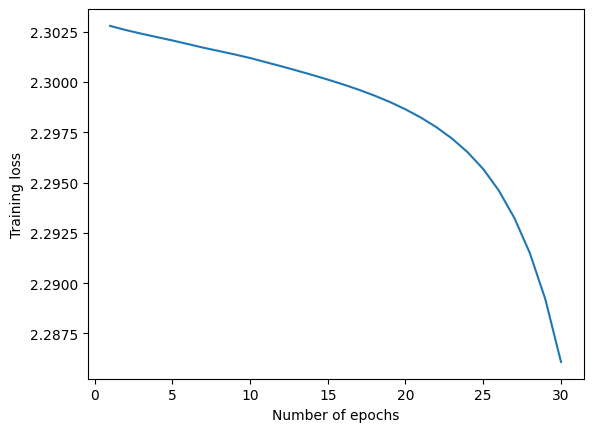

In [ ]:
#Defining the model hyper parameters
num_epochs = 30
learning_rate = 0.001
momentum = 0.9
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate, momentum=momentum)

#Training process begins
train_loss_list = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")

Accuracy on the test set: 19.5000%


Hence, in the case of mini-batch gradient descent with momentum as well, the accuracy on the test set is quite less. So, using Adam optimizer is the best choice in this case for a learning rate=0.001

**OPTIONAL PART:** I will be perfroming Stochastic gradient descent with(that is a form of mini-batch gradient descent with batch size=1)

In [ ]:
batch_size = 1
trainloader_2 = torch.utils.data.DataLoader(normalized_training_set, batch_size=batch_size, shuffle=True)
testloader_2 = torch.utils.data.DataLoader(normalized_test_set, batch_size=batch_size, shuffle=False)

In [ ]:
num_epochs = 30
learning_rate = 0.001
momentum = 0.9
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate, momentum=momentum)

#Training process begins
train_loss_list = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model.train()
	for i, (images, labels) in enumerate(trainloader_2):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list.append(train_loss/len(trainloader_2))
	print(f"Training loss = {train_loss_list[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


Epoch 1/30: Training loss = 1.8354413278301558
Epoch 2/30: Training loss = 1.538168882592519
Epoch 3/30: Training loss = 1.5072242976804575
Epoch 4/30: Training loss = 1.4955490562697251
Epoch 5/30: Training loss = 1.490276513717572
Epoch 6/30: Training loss = 1.4849954907774925
Epoch 7/30: Training loss = 1.4832126101255416
Epoch 8/30: Training loss = 1.480580398217837
Epoch 9/30: Training loss = 1.4793668199876944
Epoch 10/30: Training loss = 1.4775011581718922
Epoch 11/30: 

Using Google Colab, I could train upto 10 complete Epochs only.(my GPU access ended as it was consuming a lot of time). We can see that the Training loss is decreasing in a well behaved manner in this case

So, the **best Optimizer** choice is **Adam Optimizer** and it provides the best results when I **Normalize the dataset**(for the model I have created). So, I will be using these criterias and my ResNet model(my_model) and modify the model by increasing the **network depth**.

(a) Modified ResNet with **4 ResNet layers** and **2 fully connected layers**

In [ ]:
# Defining a convolutional layer with 3x3 kernel
def convo(input_channels, output_channels, stride=1):
    return nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=True)

# Defining a basic residual block with skip connection
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = convo(input_channels, output_channels, stride)
        self.conv2 = convo(output_channels, output_channels)
        self.shortcut = nn.Sequential()
        if(stride != 1 or input_channels != output_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        output = nn.ReLU()(self.conv1(x))
        output = (self.conv2(output))
        output = output + self.shortcut(x)  # Adding the shortcut(residual) connection
        output = nn.ReLU()(output)
        return output

# Defining a ResNet layer
def ResNet_Layer(block, input_channels, output_channels, stride):

    layers_list=[]
    layers_list.append(block(input_channels, output_channels, stride))
    input_channels = output_channels  # Update input channels for next block in the layer
    return nn.Sequential(*layers_list)

# Define the ResNet architecture
def ResNet(num_classes=10):
    layers_list = [
        convo(1, 16),        # Input channels: 1 (grayscale image), Output channels: 16
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer(as demonstrated in class)
        ]
    layers_list.append(ResNet_Layer(Block, 16, 16, 1))  # First ResNet level
    layers_list.append(ResNet_Layer(Block, 16, 32, 2))  # Second ResNet level
    layers_list.append(ResNet_Layer(Block, 32, 64, 2))  # Third ResNet level
    layers_list.append(ResNet_Layer(Block, 64, 128, 2))  # Fourth ResNet level
    # Average pooling
    layers_list.append(nn.AdaptiveAvgPool2d((1, 1))) # Average Pooling layer before Flatten(as demonstrated in class)
    layers_list.append(nn.Flatten())
    # Fully connected layers
    layers_list.append(nn.Linear(128, 32))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Linear(32, num_classes))  # Output layer with num_classes neurons
    layers_list.append(nn.Sigmoid())
    return nn.Sequential(*layers_list)

# Testing the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model_3=ResNet().to(device)
print(my_model_3)
summary(my_model_3, input_size=(1, 28, 28)) # As input size of each image in MNIST is (1 x 28 x 28)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
    )
  )
  (4): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      )
    )
  )
  (5): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(32, 64, kernel_

The total no. of trainable parameters in the above model(my_model_3) is 310986

(b) Modified ResNet architecture with **2 level ResNet layer** and **4 Fully connected layers**

In [ ]:
# Define a convolutional layer with 3x3 kernel
def convo(input_channels, output_channels, stride=1):
    return nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=True)

# Define a basic residual block with skip connection
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = convo(input_channels, output_channels, stride)
        self.conv2 = convo(output_channels, output_channels)
        self.shortcut = nn.Sequential()
        if(stride != 1 or input_channels != output_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        output = nn.ReLU()(self.conv1(x))
        output = (self.conv2(output))
        output = output + self.shortcut(x)  # Add the shortcut connection
        output = nn.ReLU()(output)
        return output

# Define a ResNet layer which contains multiple residual blocks
def ResNetLayer(block, input_channels, output_channels, stride):

    layers_list=[]
    layers_list.append(block(input_channels, output_channels, stride))
    input_channels = output_channels  # Update input channels for next block in the layer
    return nn.Sequential(*layers_list)

# Define the ResNet architecture
def ResNet(num_classes=10):
    # Start with a 3x3 convolutional layer, followed by batch normalization and ReLU
    layers_list = [
        convo(1, 16),        # Input channels: 1 (grayscale image), Output channels: 16
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer(as demonstrated in class)
        ]
    layers_list.append(ResNetLayer(Block, 16, 16, 1))  # First ResNet level
    layers_list.append(ResNetLayer(Block, 16, 32, 2))  # Second ResNet level

    # Global average pooling
    layers_list.append(nn.AdaptiveAvgPool2d((1, 1))) # Average Pooling layer before Flatten(as demonstrated in class)
    layers_list.append(nn.Flatten())
    # Fully connected layers
    layers_list.append(nn.Linear(32, 128))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Linear(128, 64))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Linear(64, 32))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Linear(32, num_classes))  # Output layer with num_classes neurons
    layers_list.append(nn.Sigmoid())
    return nn.Sequential(*layers_list)

# Testing the network
#my_model=ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model_4=ResNet().to(device)
print(my_model_4)
summary(my_model_4, input_size=(1, 28, 28)) # As input size of each image in MNIST is (1 x 28 x 28)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
    )
  )
  (4): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      )
    )
  )
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32, out_features=128, bias=True)
  (8): ReLU(inplace=True)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU(inplace=True)
  (11)

The total no. of trainable parameters in the above model(my_model_4) is 34122(It is quite less as compared to my_model_3)

Epoch 1/30: Training loss = 1.6851886278390884
Epoch 2/30: Training loss = 1.5105963295698166
Epoch 3/30: Training loss = 1.491760774254799
Epoch 4/30: Training loss = 1.4847231847047806
Epoch 5/30: Training loss = 1.4800428181886673
Epoch 6/30: Training loss = 1.4776175475120545
Epoch 7/30: Training loss = 1.475441467165947
Epoch 8/30: Training loss = 1.4738379859924315
Epoch 9/30: Training loss = 1.4719174271821975
Epoch 10/30: Training loss = 1.4727036333084107
Epoch 11/30: Training loss = 1.4711235022544862
Epoch 12/30: Training loss = 1.4702631628513336
Epoch 13/30: Training loss = 1.4707306241989135
Epoch 14/30: Training loss = 1.4701442217826843
Epoch 15/30: Training loss = 1.4691329193115235
Epoch 16/30: Training loss = 1.4690225291252137
Epoch 17/30: Training loss = 1.4702441066503524
Epoch 18/30: Training loss = 1.4707141035795213
Epoch 19/30: Training loss = 1.47031514108181
Epoch 20/30: Training loss = 1.4688447761535643
Epoch 21/30: Training loss = 1.4684760230779648
Epoch

Text(0, 0.5, 'Training loss')

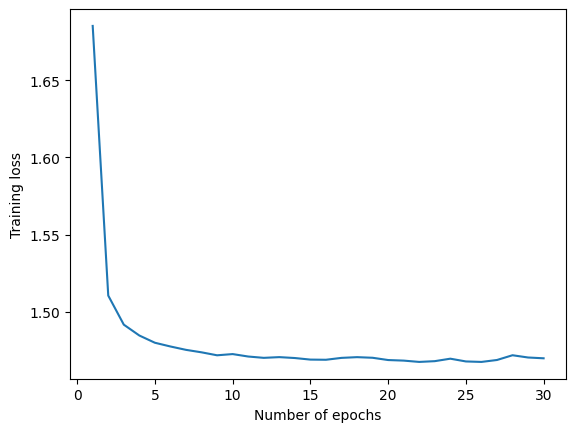

In [ ]:
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model_3.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_ResNet = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model_3.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model_3(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_ResNet.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list_ResNet[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_ResNet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model_3.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model_3(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")

Accuracy on the test set: 98.4300%


**Training for part(b)**, **using my_model_4**

Epoch 1/30: Training loss = 2.0832392209768296
Epoch 2/30: Training loss = 1.8444063395261765
Epoch 3/30: Training loss = 1.731382098197937
Epoch 4/30: Training loss = 1.651612993478775
Epoch 5/30: Training loss = 1.6019245433807372
Epoch 6/30: Training loss = 1.583406319618225
Epoch 7/30: Training loss = 1.5688291895389557
Epoch 8/30: Training loss = 1.5561510133743286
Epoch 9/30: Training loss = 1.5451723140478135
Epoch 10/30: Training loss = 1.533695387840271
Epoch 11/30: Training loss = 1.5241873687505723
Epoch 12/30: Training loss = 1.5171592050790788
Epoch 13/30: Training loss = 1.5129813295602799
Epoch 14/30: Training loss = 1.5107858687639237
Epoch 15/30: Training loss = 1.5063431131839753
Epoch 16/30: Training loss = 1.5029900753498078
Epoch 17/30: Training loss = 1.499893872141838
Epoch 18/30: Training loss = 1.4980750918388366
Epoch 19/30: Training loss = 1.49758245408535
Epoch 20/30: Training loss = 1.4939591413736344
Epoch 21/30: Training loss = 1.4918953090906144
Epoch 22

Text(0, 0.5, 'Training loss')

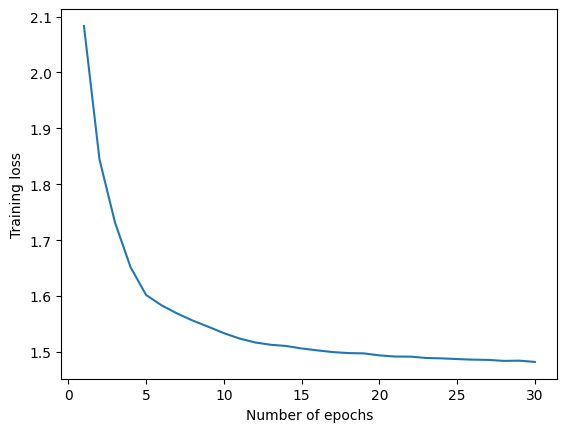

In [ ]:
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model_4.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_ResNet = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model_4.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model_4(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_ResNet.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list_ResNet[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_ResNet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model_4.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model_4(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")

Accuracy on the test set: 97.2500%


Hence, the accuracy on the test set is more in case of my_model_3(98.43%) as compared to my_model_4(97.25%)

**EXPERIMENT 5 : Part(a)**

Next I have used my_model(the model with 2 ResNet layers and 2 Fully-connected layers), used normalized dataset and Adam Optimizer and incorporated Batch Normalization this time. I named my complete training model as **my_model_5**

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define a convolutional layer with 3x3 kernel
def convo(input_channels, output_channels, stride=1):
    return nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# Define a basic residual block with skip connection
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = convo(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.conv2 = convo(output_channels, output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.shortcut = nn.Sequential()
        if (stride != 1) or (input_channels != output_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )

    def forward(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        output = output + self.shortcut(x)
        output = F.relu(output)
        return output

# Define a ResNet layer which contains multiple residual blocks
def ResNet_Layer(block, input_channels, output_channels, stride):
    layers_list = []
    layers_list.append(block(input_channels, output_channels, stride))
    input_channels = output_channels
    return nn.Sequential(*layers_list)

# Define the ResNet architecture
def ResNet(num_classes=10):
    # Start with a 3x3 convolutional layer, followed by batch normalization and ReLU
    layers_list = [
        convo(1, 16),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ]
    # Add the ResNet layers
    layers_list.append(ResNet_Layer(Block, 16, 16, 1))
    layers_list.append(ResNet_Layer(Block, 16, 32, 2))
    # Global average pooling
    layers_list.append(nn.AdaptiveAvgPool2d((1, 1)))
    layers_list.append(nn.Flatten())
    # Fully connected layers
    layers_list.append(nn.Linear(32, 64))
    layers_list.append(nn.BatchNorm1d(64))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Linear(64, num_classes))
    layers_list.append(nn.Sigmoid())
    return nn.Sequential(*layers_list)




# Testing the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model_5=ResNet().to(device)
print(my_model_5)
summary(my_model_5, input_size=(1, 28, 28)) # As input size of each image in MNIST is (1 x 28 x 28)



Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (5): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_siz

Epoch 1/30: Training loss = 1.734516059756279
Epoch 2/30: Training loss = 1.5070467406511308
Epoch 3/30: Training loss = 1.4846214658021928
Epoch 4/30: Training loss = 1.477316240668297
Epoch 5/30: Training loss = 1.4734938871860503
Epoch 6/30: Training loss = 1.4709680557250977
Epoch 7/30: Training loss = 1.4695411157608032
Epoch 8/30: Training loss = 1.4683222198486328
Epoch 9/30: Training loss = 1.4675450724363328
Epoch 10/30: Training loss = 1.4670164531469345
Epoch 11/30: Training loss = 1.4660209971666336
Epoch 12/30: Training loss = 1.465417641401291
Epoch 13/30: Training loss = 1.465280590057373
Epoch 14/30: Training loss = 1.464589700102806
Epoch 15/30: Training loss = 1.464757782816887
Epoch 16/30: Training loss = 1.4640993452072144
Epoch 17/30: Training loss = 1.4640498566627502
Epoch 18/30: Training loss = 1.4638570898771286
Epoch 19/30: Training loss = 1.463851182460785
Epoch 20/30: Training loss = 1.4631124585866928
Epoch 21/30: Training loss = 1.463555969595909
Epoch 22/

Text(0, 0.5, 'Training loss')

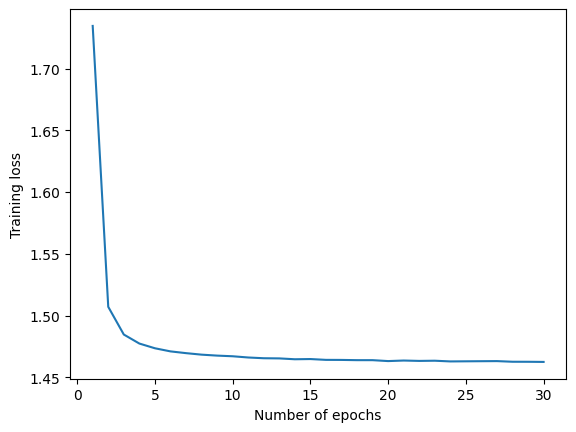

In [ ]:
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model_5.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_ResNet = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model_5.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model_5(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_ResNet.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list_ResNet[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_ResNet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model_5.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model_5(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")

Accuracy on the test set: 98.8300%


Hence, the accuracy has increased(98.83%) now(in my_model_5) as compared to when I did not use Batch-Normalization(97.35% in my_model)

**EXPERIMENT - 5 (B)**

Next, I have introduced **Dropout** in between different layers of **my_model** and named it **my_model_6**

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define a convolutional layer with 3x3 kernel
def convo(input_channels, output_channels, stride=1):
    return nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# Define a basic residual block with skip connection
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, dropout_prob=0.25):
        super(Block, self).__init__()
        self.conv1 = convo(input_channels, output_channels, stride)
        self.dropout = nn.Dropout2d(dropout_prob)
        self.conv2 = convo(output_channels, output_channels)
        self.shortcut = nn.Sequential()
        if (stride != 1) or (input_channels != output_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        output = F.relu(self.conv1(x))
        output = self.dropout(output)
        output = self.conv2(output)
        output = output + self.shortcut(x)
        output = F.relu(output)
        return output

# Defining a ResNet layer
def ResNet_Layer(block, input_channels, output_channels, stride, dropout_prob=0.25):
    layers_list = []
    layers_list.append(block(input_channels, output_channels, stride, dropout_prob))
    input_channels = output_channels
    return nn.Sequential(*layers_list)

# Defining the ResNet architecture
def ResNet(num_classes=10, dropout_prob=0.0):
    # Start with a 3x3 convolutional layer, followed by dropout and ReLU
    layers_list = [
        convo(1, 16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ]
    # Adding the ResNet layers
    layers_list.append(ResNet_Layer(Block, 16, 16, 1, dropout_prob)) # ResNet layer 1
    layers_list.append(ResNet_Layer(Block, 16, 32, 2, dropout_prob)) # ResNet layer 2
    # Average pooling
    layers_list.append(nn.AdaptiveAvgPool2d((1, 1)))
    layers_list.append(nn.Flatten())
    # Fully connected layers
    layers_list.append(nn.Linear(32, 64))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Dropout(dropout_prob))
    layers_list.append(nn.Linear(64, num_classes))
    layers_list.append(nn.Sigmoid())
    return nn.Sequential(*layers_list)

# Testing the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model_6=ResNet(dropout_prob=0.25).to(device)
print(my_model_6)
summary(my_model_6, input_size=(1, 28, 28)) # As input size of each image in MNIST is (1 x 28 x 28)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout2d(p=0.25, inplace=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
  )
  (4): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (dropout): Dropout2d(p=0.25, inplace=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
      )
    )
  )
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7)

The no. of training parameters in the above model is 21,850

Epoch 1/30: Training loss = 2.0670394819974898
Epoch 2/30: Training loss = 1.7110178536176681
Epoch 3/30: Training loss = 1.6252529621124268
Epoch 4/30: Training loss = 1.5905085039138793
Epoch 5/30: Training loss = 1.5714120489358903
Epoch 6/30: Training loss = 1.555225437283516
Epoch 7/30: Training loss = 1.5450696676969529
Epoch 8/30: Training loss = 1.5371146607398987
Epoch 9/30: Training loss = 1.5299876153469085
Epoch 10/30: Training loss = 1.5244574415683747
Epoch 11/30: Training loss = 1.5206332784891128
Epoch 12/30: Training loss = 1.5160731446743012
Epoch 13/30: Training loss = 1.5130604594945907
Epoch 14/30: Training loss = 1.5123312932252884
Epoch 15/30: Training loss = 1.5095250868797303
Epoch 16/30: Training loss = 1.5063100582361222
Epoch 17/30: Training loss = 1.5047190362215042
Epoch 18/30: Training loss = 1.5019687044620513
Epoch 19/30: Training loss = 1.5016724771261216
Epoch 20/30: Training loss = 1.5009178334474564
Epoch 21/30: Training loss = 1.4995246094465255
Ep

Text(0, 0.5, 'Training loss')

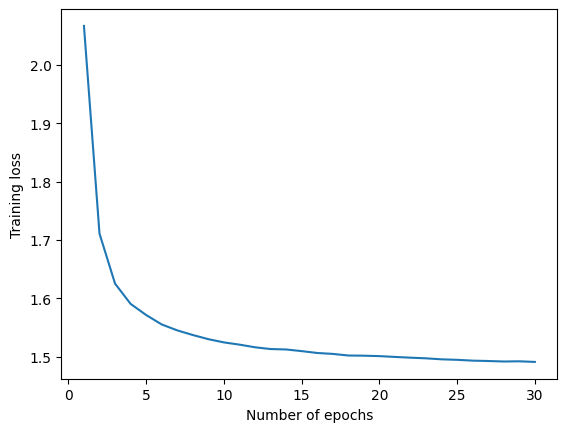

In [ ]:
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model_6.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_ResNet = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model_6.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model_6(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_ResNet.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list_ResNet[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_ResNet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model_6.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model_6(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")

Accuracy on the test set: 97.7100%


Hence, the above model gives an accuracy of 97.71%.

**EXPERIMENT NO - 5(C)**

I have introduced both **Batch Normalization and Dropout** in my_model. I have named it my_model_7

In [ ]:
# Define a convolutional layer with 3x3 kernel
def convo(input_channels, output_channels, stride=1):
    return nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# Define a basic residual block with skip connection
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, dropout_prob=0.25):
        super(Block, self).__init__()
        self.conv1 = convo(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.dropout = nn.Dropout2d(dropout_prob)
        self.conv2 = convo(output_channels, output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.shortcut = nn.Sequential()
        if (stride != 1) or (input_channels != output_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output += self.shortcut(x)
        output = F.relu(output)
        return output

# Define a ResNet layer which contains multiple residual blocks
def ResNet_Layer(block, input_channels, output_channels, stride, dropout_prob=0.25):
    layers_list = []
    layers_list.append(block(input_channels, output_channels, stride, dropout_prob))
    input_channels = output_channels
    return nn.Sequential(*layers_list)

# Define the ResNet architecture
def ResNet(num_classes=10, dropout_prob=0.25):
    # Start with a 3x3 convolutional layer, followed by batch normalization and ReLU
    layers_list = [
        convo(1, 16),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    ]
    # Add the ResNet layers
    layers_list.append(ResNet_Layer(Block, 16, 16, 1, dropout_prob))
    layers_list.append(ResNet_Layer(Block, 16, 32, 2, dropout_prob))
    # Global average pooling
    layers_list.append(nn.AdaptiveAvgPool2d((1, 1)))
    layers_list.append(nn.Flatten())
    # Fully connected layers
    layers_list.append(nn.Linear(32, 64))
    layers_list.append(nn.BatchNorm1d(64))
    layers_list.append(nn.ReLU(inplace=True))
    layers_list.append(nn.Dropout(dropout_prob))
    layers_list.append(nn.Linear(64, num_classes))
    layers_list.append(nn.Sigmoid())
    return nn.Sequential(*layers_list)

# Testing the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model_7=ResNet(dropout_prob=0.25).to(device)
print(my_model_7)
summary(my_model_7, input_size=(1, 28, 28)) # As input size of each image in MNIST is (1 x 28 x 28)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.25, inplace=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (5): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_st

The no. of training parameters in the above model is 22,226

Epoch 1/30: Training loss = 1.8573263615369797
Epoch 2/30: Training loss = 1.5609987473487854
Epoch 3/30: Training loss = 1.5157232695817948
Epoch 4/30: Training loss = 1.50079632461071
Epoch 5/30: Training loss = 1.4937890857458114
Epoch 6/30: Training loss = 1.4892255336046218
Epoch 7/30: Training loss = 1.4861291074752807
Epoch 8/30: Training loss = 1.4838412845134734
Epoch 9/30: Training loss = 1.482071503996849
Epoch 10/30: Training loss = 1.4806493294239045
Epoch 11/30: Training loss = 1.479507222175598
Epoch 12/30: Training loss = 1.4782087129354478
Epoch 13/30: Training loss = 1.4775219279527665
Epoch 14/30: Training loss = 1.4767416936159135
Epoch 15/30: Training loss = 1.476163199543953
Epoch 16/30: Training loss = 1.4761428254842759
Epoch 17/30: Training loss = 1.475425792336464
Epoch 18/30: Training loss = 1.474561779499054
Epoch 19/30: Training loss = 1.4737647479772569
Epoch 20/30: Training loss = 1.4735556358098985
Epoch 21/30: Training loss = 1.4731843763589858
Epoch 22

Text(0, 0.5, 'Training loss')

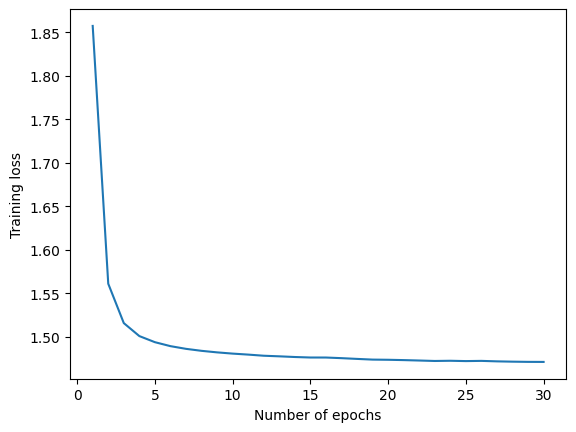

In [ ]:
num_epochs = 30
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model_7.parameters(), lr=learning_rate)

#Training process begins
train_loss_list_ResNet = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0

	#Iterating over the training dataset in batches
	my_model_7.train()
	for i, (images, labels) in enumerate(trainloader):

		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = my_model_7(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss += loss.item()

	#Printing loss for each epoch
	train_loss_list_ResNet.append(train_loss/len(trainloader))
	print(f"Training loss = {train_loss_list_ResNet[-1]}")

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list_ResNet)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Evaluation mode
my_model_7.eval()

# Lists to store predictions and ground truth labels
predicted_outputs = []
ground_truth_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in testloader:
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = my_model_7(images)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to lists
        predicted_outputs.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = sum([1 if pred == true else 0 for pred, true in zip(predicted_outputs, ground_truth_labels)])
total = len(ground_truth_labels)
accuracy = correct / total * 100

print(f"Accuracy on the test set: {accuracy:.4f}%")

Accuracy on the test set: 99.1400%


Hence, if I use both Batch Normalization and Dropout together, it gives the best accuracy in my test set.

Therefore, among 5(a), 5(b) and 5(c), the increasing order of accuracies is 5(c)> 5(a) > 5(b)

The best choice among the 3 cases will be the 3rd one [that is part (C)], as the accuracy on test set is 99.14% and also no. of trainable parameters also do not differ much amongst the 3 cases(and hence, so does the computation cost).